In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import xgboost as xgb
import shap
import joblib

In [14]:
data_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = pd.read_csv(data_path)

In [15]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
data.replace(" ", np.nan, inplace=True)
data.dropna(inplace=True)

In [17]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [18]:
label_encoders = {}
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [19]:
X = data.drop(columns=['customerID', 'Churn'])
y = data['Churn']

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True),
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500)
}

In [24]:
results = {}
best_model = None
best_auc = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)
    results[name] = {"Accuracy": accuracy, "AUC": auc, "F1 Score": f1}

    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

    if auc > best_auc:
        best_auc = auc
        best_model = model

Logistic Regression Performance:
Accuracy: 0.7939
AUC-ROC: 0.8345
F1 Score: 0.5927
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1033
           1       0.62      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407

Random Forest Performance:
Accuracy: 0.7811
AUC-ROC: 0.8108
F1 Score: 0.5375
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407

Support Vector Machine Performance:
Accuracy: 0.7854
AUC-ROC: 0.7842
F1 Score: 0.5410
              precision    recall  f1-score   support

           0       0.83      0.90      0.86  

In [25]:
joblib.dump(best_model, "best_churn_model.pkl")
print("Best model saved.")

Best model saved.


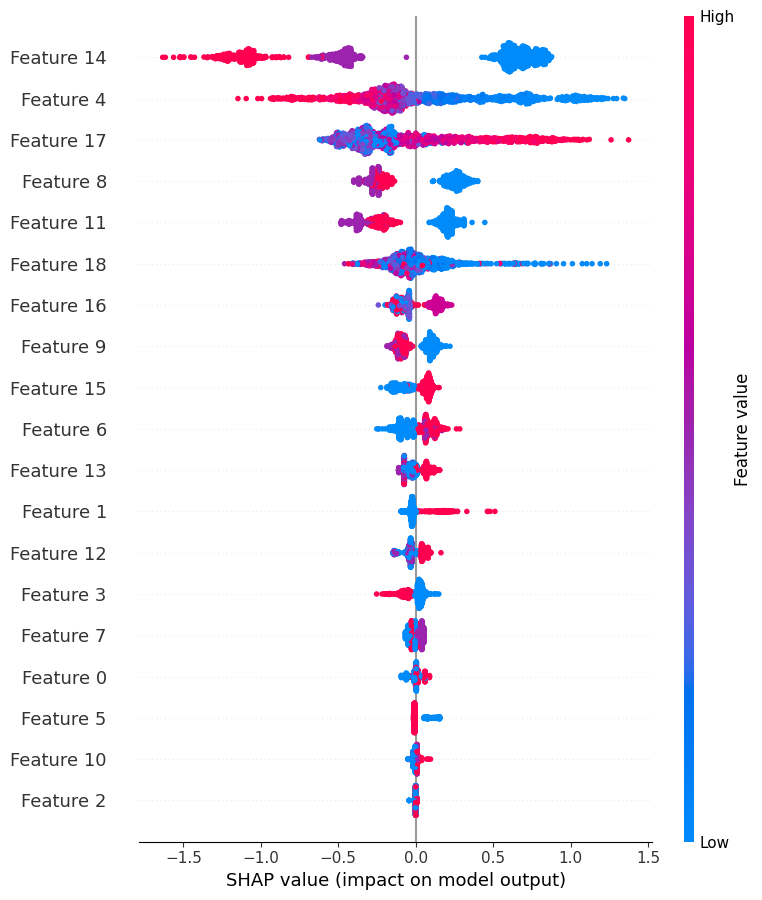

In [26]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

<ipython-input-27-fb44e70efb92>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["AUC"], palette='magma')


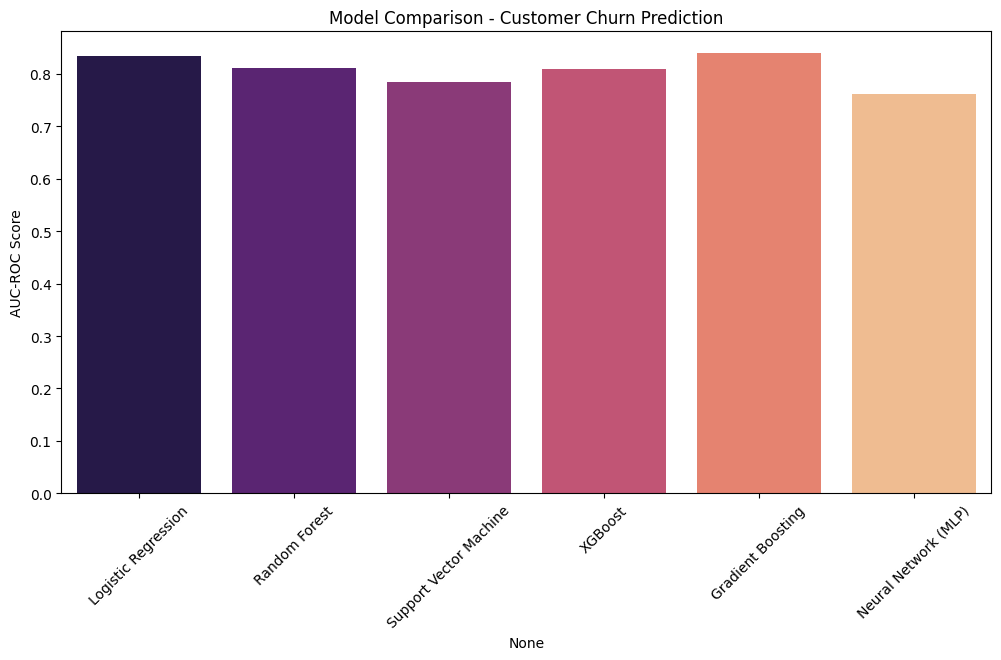

In [27]:
results_df = pd.DataFrame(results).T
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["AUC"], palette='magma')
plt.ylabel("AUC-ROC Score")
plt.title("Model Comparison - Customer Churn Prediction")
plt.xticks(rotation=45)
plt.show()